# Imports and functions

In [1]:
import linecache
import os
import time
from itertools import product
import numpy as np             # 1.20.3
import pandas as pd            # 1.3.4
from scipy.stats import zscore # 1.7.1
import matplotlib              # 3.4.3
import matplotlib.pyplot as plt


class BinaryStar:
    def __init__(self, name, model_to_fit, dir_obs, distance, distance_err, free_para, filters_to_drop=[], verbose=True):
        # initialise the binary star
        self.name               = name
        self.model_to_fit       = model_to_fit
        self.dir_obs            = dir_obs
        self.distance           = distance
        self.distance_err       = distance_err
        self.free_para          = free_para # 2 for Kurucz logg, T + 1 for model_to_fit Teff
        self.model_to_fit_short = self.model_to_fit[:self.model_to_fit.rfind("_")]
        self.star_type          = 'binary'
        self.filters_to_drop    = filters_to_drop
        if verbose: print('======== %s ========' %self.name)
        
    def read_A_comp_from_VOSA(self, verbose=True):
        # Reading single component fitted data from VOSA
        file_A = self.dir_obs + self.name +'/bestfitp/'+ self.name +'.bfit.phot.dat'
        flux_A = pd.read_csv(file_A, engine='python', comment='#',delim_whitespace= True, skipinitialspace=True, header=None)
        
        # Reading parameters derived by VOSA
        T_text    = linecache.getline(file_A, 9)
        Teff_A    = get_number_from_string(T_text)
        logg_text = linecache.getline(file_A, 10)
        logg_A    = get_number_from_string(logg_text)
        sf_text   = linecache.getline(file_A, 13)
        sf_A      = get_number_from_string(sf_text)
        R_text    = linecache.getline(file_A, 29)
        R_A       = get_number_from_string(R_text)  
        L_text    = linecache.getline(file_A, 37)
        L_A       = get_number_from_string(L_text)      
        
        # Reading the column names and fit parameters automatically
        flux_A_col     = pd.read_csv(file_A, engine='python',delim_whitespace= True,skipinitialspace=True,skiprows=39, nrows=1,escapechar='#', header=None)
        flux_A_col     = flux_A_col.drop([0], axis=1)
        flux_A.columns = flux_A_col.values[0]
        flux_A         = flux_A.set_index('FilterID')
        
        # Replacing zeros in errors with 110% of max error
        flux_A['_Error_fraction']              = flux_A['Error']/flux_A['Flux']
        flux_A.loc[flux_A.Error == 0, 'Error'] = flux_A['Flux']*(flux_A['_Error_fraction'].max()*1.1)
        # Recalculating _Errors_fraction 
        flux_A['_Error_fraction']              = flux_A['Error']/flux_A['Flux']

        # Updating the BinaryStar object with A component parameter
        self.flux_A   = flux_A
        self.Teff_A   = Teff_A
        self.logg_A   = logg_A
        self.sf_A     = sf_A
        self.L_A      = L_A
        self.R_A      = R_A
        self.N_points = len(self.flux_A)
        self.N_Np     = self.N_points-self.free_para
        
        # Remove some filters from the above file if necessary
        self.drop_filters(verbose=True)
        
        if verbose:
            print('\nRUNNING: read_A_comp_from_VOSA ')
            print('A-Component fit parameters:' )
            print(T_text[:-1],    '--> ', Teff_A)
            print(logg_text[:-1], '--> ', logg_A)
            print(sf_text[:-1],   '--> ', sf_A)
            print(R_text[:-1],    '--> ', R_A)
            print(L_text[:-1],    '--> ', L_A)
            print('      WARNING: check if the A component parameters are correctly read (VOSA sometimes changes linenumbers)')  
            print('Total filters: %d' %len(flux_A))
        '''
        flux_A_col.values[0]     # The column names in the file are as follows: 
                FilterID, Wavelength, Obs.Flux, Obs.Error, Flux, Error, FluxMod, Fitted, Excess, FitExc, UpLim
                We are interested in 
                          Flux, Error (extinction corrected observed flux and error)
                          FluxMod (Model Flux of the cooler component fitted by VOSA)
                Residual will be 'Flux-FluxMod'
                This residual will be fitted with B-component
        '''     

        
    def drop_filters(self, verbose=True):
        '''
        Some filters will have to be removed while fitting.
            e.g. bad quality photometry which is given by UpLim
        In case of IR excess, you can remove Wise filters
        For bad chi2, you can remove specific filters
        '''    
        # Select a set of filters which were Fitted or given excess
        # Removing points with upper limits or FitExcess
        self.flux_A['UpLim']        = self.flux_A['UpLim'].replace(['---'],0)
        self.flux_A['UpLim']        = self.flux_A['UpLim'].replace(['1'],1)
        self.flux_A['FitExc']       = self.flux_A['FitExc'].replace(['---'],0)
        self.flux_A['FitExc']       = self.flux_A['FitExc'].replace(['1'],1)
        self.flux_A['to_be_fitted'] = self.flux_A.Fitted+self.flux_A.Excess+self.flux_A.FitExc+self.flux_A.UpLim

        self.not_fitted_A = self.flux_A[(self.flux_A['to_be_fitted']!=1)]
        self.flux_A       = self.flux_A[(self.flux_A['to_be_fitted']==1)]

        for filter_name in self.filters_to_drop:
            self.not_fitted_A = pd.concat([self.not_fitted_A, self.flux_A[(self.flux_A.index==filter_name)]])
            self.flux_A       = self.flux_A.drop(index=filter_name)
         
        self.N_points = len(self.flux_A)
        self.N_Np     = self.N_points-self.free_para
        
        # printing filters to be fitted and not_fitted
        if verbose:
            _t1, _t2             = pd.DataFrame(),pd.DataFrame()    
            _t1['to_be_fitted']  = self.flux_A.index.values
            _t1['Wavelength']    = self.flux_A.Wavelength.values
            _t1                  = _t1.set_index('Wavelength')
            _t2['not_fitted_A']  = self.not_fitted_A.index.values
            _t2['Wavelength']    = self.not_fitted_A.Wavelength.values
            _t2                  = _t2.set_index('Wavelength')
            _filter_table        = pd.concat([_t1,_t2],sort=True)    
            print('\nRUNNING: drop_filters ')
            print(_filter_table.sort_index().fillna(''))
            print('Filters to fit: %d' %len(self.flux_A))

            
    def visualise_A_component_SED(self,excess_cutoff=0.5,save_plot=True):
        f, axes = plt.subplots(figsize=(6,4),nrows = 2, ncols = 1)
        [axi.set_axis_off() for axi in axes.ravel()]
        axes[0] = f.add_axes([0.15, 0.35, 0.8, 0.55])
        axes[1] = f.add_axes([0.15, 0.15, 0.8, 0.2])
        ####################### SED
        axes[0].scatter(self.not_fitted_A['Wavelength'], self.not_fitted_A['Flux'], color='k', marker='o',label ='No Fit', s=30, facecolors='none')
        axes[0].plot(self.flux_A['Wavelength'], self.flux_A['FluxMod'], color='green', linestyle='-',label ='Model', lw=1)
        matplotlib.rcParams.update({'errorbar.capsize': 4})
        axes[0].errorbar(self.flux_A['Wavelength'], self.flux_A['Flux'], yerr=self.flux_A['Error'],color='k', label='Obs',fmt='none',lw=2)
        ########## Fractional residual
        flux_A_excess = self.flux_A[((self.flux_A['Flux']-self.flux_A['FluxMod'])/self.flux_A['Flux']>excess_cutoff)]
        axes[1].scatter(flux_A_excess['Wavelength'], (flux_A_excess['Flux']-flux_A_excess['FluxMod'])/flux_A_excess['Flux'], color='red',marker='o',label ='Excess (%d)' %len(flux_A_excess), s=30)
        axes[1].plot(self.flux_A['Wavelength'], (self.flux_A['Flux']-self.flux_A['FluxMod'])/self.flux_A['Flux'], color='green', linestyle='-',label ='Model', lw=1)
        axes[1].errorbar(self.flux_A['Wavelength'], self.flux_A['Flux']-self.flux_A['Flux'], yerr=self.flux_A['Error']/self.flux_A['Flux'],color='k', label='Fractional Error',fmt='none',lw=2)
        ####################### Titles and labels
        label_A = 'A (' + str(self.Teff_A) + ' K, logg=' + str(self.logg_A) + ')'
        axes[0].set_title(self.name + '       ' + label_A, x=0, y=1, ha='left')
        axes[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA$$^{-1}$)')
        axes[1].set_ylabel('Residual')
        axes[1].set_xlabel('Wavelength ($\AA$)')
        ####################### axes range and scales
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[1].set_xscale('log')
        wave_min = min(self.flux_A['Wavelength'].min(), self.not_fitted_A['Wavelength'].min())
        wave_max = max(self.flux_A['Wavelength'].max(), self.not_fitted_A['Wavelength'].max())
        flux_min = min(self.flux_A['Flux'].min(),  self.not_fitted_A['Flux'].min())
        flux_max = max(self.flux_A['Flux'].max(),  self.not_fitted_A['Flux'].max())
        axes[0].set_xlim([wave_min/1.2,wave_max*1.2])
        axes[0].set_ylim([flux_min/5,flux_max*5])
        axes[1].set_xlim([wave_min/1.2,wave_max*1.2])
        axes[1].set_ylim([-0.2,1.5])
        ####################### decoration    
        axes[1].axhline(excess_cutoff, ls=(0, (5, 10)), lw=2, c='0.5',zorder=0)
        plt.setp(axes[0].get_xticklabels(),visible=False)
        axes[0].grid()
        axes[1].grid()
        axes[0].tick_params(which='both', direction='out', length=4)
        axes[1].tick_params(which='both', direction='out', length=4)
        axes[0].legend(scatterpoints=1, loc='upper center', ncol=5,frameon=False,handletextpad=0.3, borderpad=0.1)
        axes[1].legend(scatterpoints=1, loc='upper right', ncol=3,frameon=False,handletextpad=0.3, borderpad=0.1)
        if save_plot: ########## Saving file   
            if not os.path.exists('outputs/binary_SEDs/'+ self.name):
                os.makedirs('outputs/binary_SEDs/'+ self.name)
            plt.savefig ('outputs/binary_SEDs/'+ self.name + '/A_SED_' +self.name+'_'+str(self.Teff_A)+'_logg'+str(self.logg_A)+'.png', format='png', dpi=300)
        # plt.show()
        
    def append_residual_to_model(self):
        # Adding the observed corrected flux and errors to the model file
        self.flux_model['flux_obs'] = self.flux_A['Flux']
        self.flux_model['flux_A']   = self.flux_A['FluxMod']
        self.flux_model['flux']     = self.flux_A['Flux'] - self.flux_A['FluxMod']
        self.flux_model['error']    = self.flux_A['Error']
        
        # error modification for calculating vgf (minimum error = 2%) and vgfb (minimum error = 10%)
        frac_error                         = self.flux_A['Error']/self.flux_A['Flux']
        self.flux_model['frac_error']      = frac_error
        self.flux_model['error_2percent']  = np.where(frac_error<0.02, 0.02, frac_error)*self.flux_A['Flux']
        self.flux_model['error_5percent']  = np.where(frac_error<0.05, 0.05, frac_error)*self.flux_A['Flux']
        self.flux_model['error_10percent'] = np.where(frac_error<0.10, 0.10, frac_error)*self.flux_A['Flux']


    def create_binary_SED_plot(self,cycle,save_plot=True,top_fits=20):
        ###################### initialising
        f, axes = plt.subplots(figsize=(12,6),nrows = 3, ncols = 3)
        [axi.set_axis_off() for axi in axes.ravel()]
        axes[0][0] = f.add_axes([0.06, 0.44, 0.49, 0.50])
        axes[1][0] = f.add_axes([0.06, 0.27, 0.49, 0.17])
        axes[2][0] = f.add_axes([0.06, 0.10, 0.49, 0.17])

        axes[0][1] = f.add_axes([0.63, 0.66, 0.30, 0.28])
        axes[1][1] = f.add_axes([0.63, 0.38, 0.30, 0.28])
        axes[2][1] = f.add_axes([0.63, 0.10, 0.30, 0.28])

        axes[0][2] = f.add_axes([0.91, 0.10, 0.02, 0.28])
        ####################### SED
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_A'], color='orange', linestyle='-.',label ='A', lw=1)
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_B'], color='dodgerblue', linestyle=(0, (5, 5)),label ='B', lw=1)
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_total'], color='green', linestyle='-',label ='Model', lw=1)
        axes[0][0].scatter(self.not_fitted_A['Wavelength'], self.not_fitted_A['Flux'], color='k', marker='o',label ='No Fit', s=30, facecolors='none')
        matplotlib.rcParams.update({'errorbar.capsize': 4})
        axes[0][0].errorbar(self.flux_model['wave'], self.flux_model['flux_obs'], yerr=self.flux_model['error'],color='k', label='Obs',fmt='none',lw=2)
        ########## Fractional residual
        axes[1][0].plot(self.flux_model['wave'], (self.flux_model['flux_obs']-self.flux_model['flux_A'])/self.flux_model['flux_obs'],label='',marker='',color='orange', linestyle='-.',lw=1)
        axes[1][0].plot(self.flux_model['wave'], (self.flux_model['flux_obs']-self.flux_model['flux_A']-self.flux_model['flux_B'])/self.flux_model['flux_obs'],label='',marker='',color='green',lw=1, linestyle='-')
        axes[1][0].errorbar(self.flux_model['wave'], self.flux_model['flux_obs']-self.flux_model['flux_obs'], yerr=self.flux_model['frac_error'],color='k', label='Obs',fmt='none',lw=2) 
        ########## chi2_i
        axes[2][0].plot(self.flux_model['wave'], self.flux_model['chi2_i'],label='',marker='o',color='green', linestyle='-',lw=1)
        ########## L vs T (HR diagram)
        x_data = self.data_chi.Teff.astype(np.float64).head(top_fits)
        y_data = lumi(radius(self.data_chi['sf'].head(top_fits), self.distance),x_data) 
        c_data = self.data_chi['vgfb2'].head(top_fits)
        axes[0][1].scatter(x_data,y_data, marker='.', label='',c=c_data, s=10,rasterized = True, zorder=1)
        axes[0][1].scatter(self.Teff_A,self.L_A, marker='s', label='A-comp',c='r', s=40,rasterized = True, zorder=2)
        axes[0][1].scatter(int(self.Teff_B),self.L_B, marker='o', label='B-comp',c='b', s=40,rasterized = True, zorder=3)
        ########## R vs T    
        x_data = self.data_chi.Teff.astype(np.float64).head(top_fits)
        y_data = radius(self.data_chi['sf'].head(top_fits),self.distance)
        cs = axes[1][1].scatter(x_data,y_data,c=c_data, cmap='summer',s=10,rasterized = True, zorder=2)
        axes[1][1].scatter(self.data_chi.Teff.astype(np.int64),radius(self.data_chi['sf'],self.distance), marker='.', c='dodgerblue', s=1,rasterized = True, zorder=0)
        ########## chi2 vs T
        y_data = self.data_chi['chi2'].head(top_fits)
        axes[2][1].scatter(x_data,y_data,c=c_data, cmap='summer',s=10,rasterized = True,zorder=2)  
        ########## colorbar
        f.colorbar(cs, cax=axes[0][2])
        cs.set_clim(c_data.min(),c_data.max())
        axes[0][2].set_ylabel('$vgf_b^2$   (Best '+str(top_fits)+' fits)')
        axes[0][2].yaxis.set_label_position("right")
        ####################### best fit lines
        axes[1][1].axvline(int(self.Teff_B), ls=(0, (5, 10)), lw=2, c='g',zorder=1)
        axes[2][1].axvline(int(self.Teff_B), ls=(0, (5, 10)), lw=2, c='g',zorder=1)
        axes[1][1].axhline(radius(self.data_chi.sf[0],self.distance), ls=(0, (5, 10)), lw=2, c='g',zorder=1)
        axes[2][1].axhline(self.data_chi.chi2[0], ls=(0, (5, 10)), lw=2, c='g',zorder=1)
        ####################### Titles and labels
        label_A = 'A (' + str(self.Teff_A) + ' $K$, logg=' + str(self.logg_A) + ')'
        label_B = 'B (' + str(self.Teff_B) + ' $K$, '+str(round(self.L_B,3)) + ' $L_{\odot}$, '+str(round(self.R_B,3)) + ' $R_{\odot}$)'
        axes[0][0].set_title(self.name+'       ' + self.model_to_fit + '       ' + label_A +'       '+ label_B, x=0, y=1, ha='left')
        axes[2][0].set_title('$\chi^2$ = '+str(round(self.data_chi.chi2[0],1))+
                             '\n$\chi_r^2$ = '+str(round(self.data_chi.chi2_r[0],2))+
                             '\n$vgf_b^2$ = '+str(round(self.data_chi.vgfb2[0],2))
                             ,x=0.98,y=0.9, ha='right', va='top')
        ####################### decoration and saving
        decoration_of_SED_plots(self,axes)
        if save_plot:   
            if not os.path.exists('outputs/binary_SEDs/'+ self.name):
                os.makedirs('outputs/binary_SEDs/'+ self.name)
            plt.savefig ('outputs/binary_SEDs/'+ self.name + '/' +self.name+'_' + self.model_to_fit +'_'+str(self.Teff_B)+'_'+str(cycle)+'.png', format='png', dpi=300)#,bbox_inches='tight')
        plt.show() 


    def create_binary_SED_plot_iterations(self,cycle,plot_noisy_SEDs=True,save_plot=True):
        ###################### initialising
        f, axes = plt.subplots(figsize=(12,6),nrows = 3, ncols = 3)
        [axi.set_axis_off() for axi in axes.ravel()]
        axes[0][0] = f.add_axes([0.06, 0.44, 0.49, 0.50])
        axes[1][0] = f.add_axes([0.06, 0.27, 0.49, 0.17])
        axes[2][0] = f.add_axes([0.06, 0.10, 0.49, 0.17])

        axes[0][1] = f.add_axes([0.63, 0.66, 0.30, 0.28])
        axes[1][1] = f.add_axes([0.63, 0.38, 0.30, 0.28])
        axes[2][1] = f.add_axes([0.63, 0.10, 0.30, 0.28])

        axes[0][2] = f.add_axes([0.91, 0.10, 0.02, 0.28])
        ####################### SED
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_A'], color='orange', linestyle='-.',label ='A', lw=1)
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_B_median'], color='dodgerblue', linestyle=(0, (5, 5)),label ='B', lw=1,zorder=3)
        axes[0][0].plot(self.flux_model['wave'], self.flux_model['flux_total_median'], color='green', linestyle='-',label ='Model', lw=1)
        axes[0][0].scatter(self.not_fitted_A['Wavelength'], self.not_fitted_A['Flux'], color='k', marker='o',label ='No Fit', s=30, facecolors='none')
        matplotlib.rcParams.update({'errorbar.capsize': 4})
        axes[0][0].errorbar(self.flux_model['wave'], self.flux_model['flux_obs'], yerr=self.flux_model['error'],color='k', label='Obs',fmt='none',lw=2)
        ########## plotting noisy fits
        if plot_noisy_SEDs:
            for idx, sf_noisy in enumerate(self.data_chi_iterations['sf']):
                Teff_noisy = self.data_chi_iterations['Teff'][idx]
                flux_B_noisy = sf_noisy * self.flux_model[Teff_noisy]
                residual_noisy = self.flux_model['flux_obs'] - self.flux_model['flux_A'] - flux_B_noisy
                axes[0][0].plot(self.flux_model['wave'], flux_B_noisy, color='cyan', linestyle='-',label='', lw=0.2, alpha=0.2,zorder=0)
                axes[0][1].plot(self.flux_model['wave'], residual_noisy, color='cyan', linestyle='-',label='', lw=0.2, alpha=0.2,zorder=0)        
        ########## Fractional residual
        axes[1][0].plot(self.flux_model['wave'], (self.flux_model['flux_obs']-self.flux_model['flux_A'])/self.flux_model['flux_obs'],label='',marker='',color='orange', linestyle='-.',lw=1,zorder=1)
        axes[1][0].plot(self.flux_model['wave'], (self.flux_model['flux_obs']-self.flux_model['flux_A']-self.flux_model['flux_B_median'])/self.flux_model['flux_obs'],label='',marker='',color='green',lw=1, linestyle='-',zorder=2)
        axes[1][0].errorbar(self.flux_model['wave'], self.flux_model['flux_obs']-self.flux_model['flux_obs'], yerr=self.flux_model['frac_error'],color='k', label='Obs',fmt='none',lw=2,zorder=3) 
        ########## chi2_i
        axes[2][0].plot(self.flux_model['wave'], self.flux_model['chi2_i_median'],label='',marker='o',color='green', linestyle='-',lw=1)
        ########## L vs T (HR diagram)
        x_data = self.data_chi_iterations.Teff.astype(np.float64)
        y_data = lumi(radius(self.data_chi_iterations['sf'], self.distance),x_data)
        c_data = self.data_chi_iterations['vgfb2']
        axes[0][1].scatter(x_data,y_data, marker='.', label='',c=c_data, s=10,cmap='summer',rasterized = True, zorder=1)    
        axes[0][1].scatter(self.Teff_A,self.L_A, marker='s', label='A-comp',c='r', s=40,rasterized = True, zorder=2)
        # x_asymmetric_error = [[self.Teff_B_error_lower],[self.Teff_B_error_upper]]
        # y_asymmetric_error = [[self.L_B_error_lower],[self.L_B_error_upper]]
        axes[0][1].scatter(self.Teff_B_median,self.L_B_median, marker='o', label='B-comp (median)',c='b',s=40, rasterized = True, zorder=3)
        # axes[0][1].scatter(int(self.Teff_B),self.L_B, marker='+', label='B-comp (least $\chi^2$)',c='0.5',s=100,rasterized = True, zorder=3 )
        ########## R vs T    
        y_data = radius(self.data_chi_iterations['sf'],self.distance)
        axes[1][1].scatter(x_data,y_data, marker='.', s=10, c=c_data,cmap='summer',rasterized = True, zorder=1)
        ########## chi2 vs T
        y_data = self.data_chi_iterations['chi2_r']
        cs = axes[2][1].scatter(x_data,y_data,c=c_data, cmap='summer',s=10, rasterized = True,zorder=2)  
        ####################### errorbars
        axes[0][1].axvspan(self.Teff_B_median-self.Teff_B_error_lower, self.Teff_B_median+self.Teff_B_error_upper, alpha=0.2, color='dodgerblue')
        axes[0][1].axhspan(self.L_B_median-self.L_B_error_lower, self.L_B_median+self.L_B_error_upper, alpha=0.2, color='dodgerblue')        
        axes[1][1].axvspan(self.Teff_B_median-self.Teff_B_error_lower, self.Teff_B_median+self.Teff_B_error_upper, alpha=0.2, color='dodgerblue')
        axes[1][1].axhspan(self.R_B_median-self.R_B_error_lower, self.R_B_median+self.R_B_error_upper, alpha=0.2, color='dodgerblue')        
        axes[2][1].axvspan(self.Teff_B_median-self.Teff_B_error_lower, self.Teff_B_median+self.Teff_B_error_upper, alpha=0.2, color='dodgerblue')
        ####################### colorbar
        f.colorbar(cs, cax=axes[0][2])
        cs.set_clim(c_data.min(),c_data.max())
        axes[0][2].set_ylabel('$vgf_b^2$')
        axes[0][2].yaxis.set_label_position("right")
        ####################### Titles and labels
        label_A = 'A (' + str(self.Teff_A) + ' $K$, logg=' + str(self.logg_A) + ')'
        label_B = 'B (' + str(int(self.Teff_B_median)) +'$^{+'+ str(int(self.Teff_B_error_upper)) + '}_{-' + str(int(self.Teff_B_error_lower)) + '}$ $K$, ' +\
                          str(round(self.L_B_median,5)) +'$^{+'+ str(round(self.L_B_error_upper,5)) + '}_{-' + str(round(self.L_B_error_lower,5)) + '}$ $L_{\odot}$, ' +\
                          str(round(self.R_B_median,5)) +'$^{+'+ str(round(self.R_B_error_upper,5)) + '}_{-' + str(round(self.R_B_error_lower,5)) + '}$ $R_{\odot}$)'
        axes[0][0].set_title(self.name+'       ' + self.model_to_fit + '       ' + label_A +'       '+ label_B, x=0, y=1, ha='left')
        axes[2][0].set_title('$\chi^2$ = '+str(round(self.chi2_median,1))+
                             '\n$\chi_r^2$ = '+str(round(self.chi2_r_median,2))+
                             '\n$vgf_b^2$ = '+str(round(self.vgfb2_median,2)),
                              x=0.98,y=0.9, ha='right', va='top')
        ####################### decoration and saving
        decoration_of_SED_plots(self,axes)
        if save_plot:   
            if not os.path.exists('outputs/binary_SEDs/'+ self.name):
                os.makedirs('outputs/binary_SEDs/'+ self.name)
            plt.savefig ('outputs/binary_SEDs/'+ self.name + '/' +self.name+'_' + self.model_to_fit +'_'+str(self.Teff_B)+'_'+str(cycle)+'_iterations.png', format='png', dpi=300)#,bbox_inches='tight')
        plt.show()  


def get_number_from_string(line): 
    # Read a float number from sentence
    for t in line.split():
        try: l = float(t)
        except ValueError: pass
    return l


def closest(lst, K):
    # Finds closest number to K in a list 
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return idx, lst[idx]


def sf_from_R(radius, distance):
    # scaling factor for given radius (in Rsun) and distance (in pc)
    return (radius/(distance*44353566.0))**2


def lumi(radius,Teff):
    # calculate luminosity from radius (in Rsun), Teff (in K)
    sigma = 5.67e-8  #W m−2 K−4
    if isinstance(Teff, str): Teff = float(Teff)
    return (sigma * 4 * 3.141592 * (radius*6.957e+8)**2 * Teff**4)/3.828e+26 # in Lsun

    
def radius(sf, distance):
    # Radius for given scaling factor and distance (in pc)
    return sf**0.5 * (distance*44353566.0) # in Rsun
    
    
def read_model_file(model_to_fit, filter_list,verbose=False):
    # read model file from the 'models' folder as a dataframe
    flux_model = pd.read_csv('models/'+model_to_fit+'.csv', engine='python')
    flux_model = flux_model.sort_values('wave')
    flux_model = flux_model.set_index('filter')
    flux_model = flux_model.loc[filter_list]
    T_list     = flux_model.columns[:-1].values
    
    # for Koester model (which has leading zeros e.g. 05000, 06000 etc.)
    for idx in range(len(T_list)):
        if T_list[idx][0]=='0': T_list[idx] = T_list[idx][1:]
    flux_model.columns = np.append(T_list, 'wave')
            
    if verbose: 
        print('\nRUNNING: read_model_file ')
        print(flux_model.index)
    return flux_model, T_list        


def test_T_sf_list():
    # Small sf and T grids for testing purpose
    sf_list = [2.513454e-25/6,2.513454e-25/5,2.513454e-25/4,2.513454e-25/3,2.513454e-25/2,2.513454e-25/1.5,2.513454e-25,2.513454e-25*1.5,2.513454e-25*2,2.513454e-25*3,2.513454e-25*4,2.513454e-25*5]
    sf_list = [2.513454e-25/3,2.513454e-25/2,2.513454e-25/1.5,2.513454e-25,2.513454e-25*1.5]#,2.513454e-25*2,2.513454e-25*3,2.513454e-25*4,2.513454e-25*5]
    T_list  = ['10000','12000','13000','14500','16000','17000','20000']
    # T_list  = ['10000','14500','20000']
    return T_list, sf_list


def calculate_fitting_parameters(flux_model,sf,Teff,data_chi,counter, noisy=False):
    '''
    http://svo2.cab.inta-csic.es/theory/vosa/helpw4.php?otype=star&action=help&what=fit
    chi2 = 1/(Ntotal-Nfree_para) * SIGMA[(flux_obs-flux_model*scaling_factor)**2/(error_observed**2)]
    vgf2 = 1/(Ntotal-Nfree_para) * SIGMA[(flux_obs-flux_model*scaling_factor)**2/(error_minimum_2_percent**2)]
    vgfb2= 1/(Ntotal-Nfree_para) * SIGMA[(flux_obs-flux_model*scaling_factor)**2/(error_minimum_10_percent**2)]
    '''
    if noisy: _residual_flux = flux_model['flux_noisy'] - sf*flux_model[Teff]
    else:     _residual_flux = flux_model['flux']       - sf*flux_model[Teff]
    _chi2_i        = _residual_flux**2 / flux_model['error']**2
    _vgf_i         = _residual_flux**2 / flux_model['error_2percent']**2
    _vgfb_i        = _residual_flux**2 / flux_model['error_10percent']**2
    sum_chi2 =  _chi2_i.sum()
    sum_vgf  =  _vgf_i.sum()
    sum_vgfb =  _vgfb_i.sum()
    data_chi.loc[counter, 'Teff']   = Teff
    data_chi.loc[counter, 'sf']     = sf
    data_chi.loc[counter, 'chi2']   = sum_chi2
    data_chi.loc[counter, 'chi2_r'] = (sum_chi2/star.N_Np)
    data_chi.loc[counter, 'vgf2']   = (sum_vgf /star.N_Np)
    data_chi.loc[counter, 'vgfb2']  = (sum_vgfb/star.N_Np)
    

def calculate_mimimizing_sf_for_Teff(star, Teff, sf_list, len_sf_list, sf_start=0, verbose=False,noisy=False):
    '''
    For a temperature, select random sf from sf_list i.e. sf_start
    Calculate whether chi2 is increasing or decreasing around the sf_start
    Change sf such that chi2 reduces
    Stop at the minimun chi2 or edges of parameter space
    '''
    if noisy: flux_obs = star.flux_model['flux_noisy']
    else:     flux_obs = star.flux_model['flux']
        
    err2       = star.flux_model['error']**2
    flux_model = star.flux_model
    
    # Calculate 3 chi2 valeus near sf_start
    _chi2_i_0  = (flux_obs - sf_list[sf_start]  *flux_model[Teff])**2 / err2
    _chi2_i_1  = (flux_obs - sf_list[sf_start+1]*flux_model[Teff])**2 / err2
    _chi2_i_2  = (flux_obs - sf_list[sf_start+2]*flux_model[Teff])**2 / err2
    sum_chi2_0 =  _chi2_i_0.sum()
    sum_chi2_1 =  _chi2_i_1.sum()
    sum_chi2_2 =  _chi2_i_2.sum()
    
    if verbose: print('\nRUNNING: calculate_mimimizing_sf_for_Teff ')
    if verbose: print('Starting conditions: sf_start= %d, T= %s' %(sf_start,Teff))
    # for chi0 > chi1 < chi2   i.e. minima at chi1
    if ((sum_chi2_1<=sum_chi2_0) & (sum_chi2_1<=sum_chi2_2)):
        sf_index   = sf_start+1
    # for chi0 < chi1 < chi2   i.e. chi2 increases with sf
    if (sum_chi2_0<=sum_chi2_1) & (sum_chi2_0<=sum_chi2_2):
        sum_chi2_x = sum_chi2_0
        sum_chi2_y = sum_chi2_1
        sf_index   = sf_start
        while ((sf_index>0) and (sum_chi2_x < sum_chi2_y)):
            _chi2_i_x  = (flux_obs - sf_list[sf_index-1]  *flux_model[Teff])**2 / err2
            _chi2_i_y  = (flux_obs - sf_list[sf_index]  *flux_model[Teff])**2 / err2
            sum_chi2_x =  _chi2_i_x.sum()
            sum_chi2_y =  _chi2_i_y.sum()
            sf_index   = sf_index-1
        if not (sum_chi2_x < sum_chi2_y): sf_index = sf_index+1
    # for chi0 > chi1 > chi2  i.e. chi2 decreases with sf
    if (sum_chi2_2<=sum_chi2_1) & (sum_chi2_2<=sum_chi2_0):
        sum_chi2_x = sum_chi2_1
        sum_chi2_y = sum_chi2_2
        sf_index   = sf_start+1
        while ((sf_index < len_sf_list-1) and (sum_chi2_y < sum_chi2_x)):
            _chi2_i_x  = (flux_obs - sf_list[sf_index]  *flux_model[Teff])**2 / err2
            _chi2_i_y  = (flux_obs - sf_list[sf_index+1]  *flux_model[Teff])**2 / err2
            sum_chi2_x =  _chi2_i_x.sum()
            sum_chi2_y =  _chi2_i_y.sum()
            sf_index   = sf_index+1
        if not (sum_chi2_y < sum_chi2_x): sf_index = sf_index-1
    
    if verbose:
        if sf_index==0:
            sum_chi2_0 = np.sum((flux_obs - sf_list[sf_index]  *flux_model[Teff])**2 / err2)
            sum_chi2_1 = np.sum((flux_obs - sf_list[sf_index+1]  *flux_model[Teff])**2 / err2)
            print('   lower_limit  at        sf_end= %d' %sf_index, '  |  chi2_values: %.2f, %.2f...' %(sum_chi2_0,sum_chi2_1))
        elif sf_index==len(sf_list)-1:
            sum_chi2_0 = np.sum((flux_obs - sf_list[sf_index-1]  *flux_model[Teff])**2 / err2)
            sum_chi2_1 = np.sum((flux_obs - sf_list[sf_index]  *flux_model[Teff])**2 / err2)
            print('   upper_limit  at        sf_end= %d' %sf_index, '  |  chi2_values: ..., %.2f, %.2f' %(sum_chi2_0,sum_chi2_1))
        elif (sf_index>0) & (sf_index<len(sf_list)-1):
            sum_chi2_0 = np.sum((flux_obs - sf_list[sf_index-1]  *flux_model[Teff])**2 / err2)
            sum_chi2_1 = np.sum((flux_obs - sf_list[sf_index]  *flux_model[Teff])**2 / err2)
            sum_chi2_2 = np.sum((flux_obs - sf_list[sf_index+1]  *flux_model[Teff])**2 / err2)
            print('   local mimima at        sf_end= %d' %sf_index, '  |  chi2_values: ...%.2f, %.2f, %.2f...' %(sum_chi2_0,sum_chi2_1,sum_chi2_2))
    return sf_index


def calculate_chi2(star, sf_list, T_list, cycle, method='minimising_grid_search',verbose=True, test=False, refit=False):
    '''
    methods: full_grid_search       = goes through all combinations of sf_list and T_list.
             minimising_grid_search = for each Teff, goes towards direction of minimising chi2. (up to 10-20 times faster). But can get stuck at local minima
    '''
    if verbose: print('\nRUNNING: calculate_chi2 ')
    
    chi2_file = 'outputs/chi_files/'+star.name+'_chi2_' +star.star_type + '_' +star.model_to_fit +'_'+str(cycle)  + '.csv'
    
    # If the chi2 file exists, it will be read (depends on refit = True or False)
    if os.path.isfile(chi2_file): 
        if not refit:
            data_chi      = pd.read_csv(chi2_file, engine='python', 
                                        dtype={'Teff':'object','sf':'float','chi2':'float','chi2_r':'float','vgf2':'float','vgfb2':'float'})
            if verbose:     print(data_chi.head())
            star.data_chi = data_chi
            return 
        if refit: print('WARNING: '+chi2_file+' file will be overwritten.')
        
    if test:     T_list, sf_list = test_T_sf_list()

    start_time = time.process_time()

    if method   == 'full_grid_search':
        data_chi = pd.DataFrame()
        count    = len(sf_list)*len(T_list)
        for counter, (sf, Teff) in enumerate(product(sf_list, T_list),1):
            calculate_fitting_parameters(star,sf,Teff,data_chi,counter)
            if (counter%100==0):  # printing progress
                print('\r Calculating chi2:  %d/%d  (%d%%)' %(counter, count, 100*counter/count), end='')

    if method       == 'minimising_grid_search':
        data_chi     = pd.DataFrame()
        count        = len(T_list)
        len_sf_list  = len(sf_list)
        for counter, Teff in enumerate(T_list):
            np.random.seed(counter+2)
            sf_start = np.random.randint(len_sf_list-2)
            sf_index = calculate_mimimizing_sf_for_Teff(star, Teff, sf_list,len_sf_list, sf_start=sf_start,verbose=False)
            calculate_fitting_parameters(star.flux_model,sf_list[sf_index],Teff,data_chi,counter)
            data_chi.loc[counter, 'sf_index']  = sf_index
            print('\r Calculating chi2:  %d/%d  (%d%%)' %(counter, count, 100*counter/count), end='')

    end_time = time.process_time()

    # Sorting by chi2 and updating the Star object
    data_chi      = data_chi.sort_values('chi2')
    data_chi      = data_chi.reset_index(drop=True)
    if verbose:     print('\r',data_chi.head())
    star.data_chi = data_chi

    if not      os.path.exists('outputs/chi_files/'): os.makedirs('outputs/chi_files/')
    data_chi.to_csv(chi2_file, index=False, header=True, sep=',')

    if verbose: print("Computation time = " + str((end_time - start_time)) + " s")
    return

    
def calculate_chi2_for_iterations(star, sf_list, T_list, cycle, total_iterations=100, verbose=True, test=False,refit=False):
    '''
    Uses minimising_grid_search = for each Teff, goes towards direction of minimising chi2. It can get stuck at local minima.
    Adds random Gaussian noise to the data (scaled according to the error) and refits for 'total_iterations' iterations.
    Best chi2 fit in each iteration is recorded in data_chi_iterations
    '''
    if verbose: print('\nRUNNING: calculate_chi2_for_iterations ')
    
    chi2_file = 'outputs/chi_files/'+star.name+'_chi2_iterations' + str(total_iterations) + '_' + star.star_type + '_' +star.model_to_fit +'_'+str(cycle)  + '.csv'

    # If the chi2 file exists, it will be read (depends on refit = True or False)
    if os.path.isfile(chi2_file): 
        if not refit:            
            data_chi_iterations = pd.read_csv(chi2_file, engine='python', 
                                              dtype={'Teff':'object','sf':'float','chi2':'float','chi2_r':'float','vgf2':'float','vgfb2':'float','seed':'float', 'radius':'float', 'luminosity':'float'})
            if verbose: print(data_chi_iterations.head())
            star.data_chi_iterations = data_chi_iterations
            return data_chi_iterations
        if refit: print('WARNING: '+chi2_file+' file will be overwritten.')
    
    if test: 
        total_iterations=3
        T_list, sf_list = test_T_sf_list()

    T_list              = star.data_chi['Teff']
    len_sf_list         = len(sf_list)
    data_chi_iterations = pd.DataFrame()

    start_time = time.process_time()
    
    # Run the chi2 calculation total_iterations times
    for seed in range (total_iterations):
        np.random.seed(seed)
        
        noise = np.random.normal(0, 1, [star.N_points]) 
        if seed == 0:    # No noise added for 1st iteration
            star.flux_model['flux_noisy'] =star.flux_model['flux'] + star.flux_model['error']*0.0 
        else:            # Adding Gaussian noise to the flux 
            star.flux_model['flux_noisy'] =star.flux_model['flux'] + star.flux_model['error']*noise
    
        _data_chi = pd.DataFrame()
        for counter, Teff in enumerate(T_list):
            sf_start = star.data_chi['sf_index'].astype(int)[counter]
            if sf_start >= len(sf_list)-2 : sf_start=sf_start-2 # to keep following code consistent

            sf_index = calculate_mimimizing_sf_for_Teff(star, Teff, sf_list, len_sf_list, sf_start=sf_start, noisy=True, verbose=False)
            calculate_fitting_parameters(star.flux_model,sf_list[sf_index],Teff,_data_chi,counter,noisy=True)

        # _data_chi saves the best chi2 model for each temperature within this iteration
        _data_chi = _data_chi.sort_values('chi2')
        _data_chi = _data_chi.reset_index(drop=True)

        # Only best fit among the _data_chi is saved corresponding to the iteration
        data_chi_iterations.loc[seed, 'seed']        = seed            
        data_chi_iterations.loc[seed, 'Teff']        = _data_chi['Teff'][0]
        data_chi_iterations.loc[seed, 'sf']          = _data_chi['sf'][0]
        data_chi_iterations.loc[seed, 'chi2']        = _data_chi['chi2'][0]        
        data_chi_iterations.loc[seed, 'chi2_r']      = _data_chi['chi2_r'][0]        
        data_chi_iterations.loc[seed, 'vgf2']        = _data_chi['vgf2'][0]        
        data_chi_iterations.loc[seed, 'vgfb2']       = _data_chi['vgfb2'][0]        
        data_chi_iterations.loc[seed, 'radius']      = radius(data_chi_iterations['sf'][seed],star.distance)
        data_chi_iterations.loc[seed, 'luminosity']  = lumi(data_chi_iterations['radius'][seed],Teff)
        
        print('\r Calculating chi2:  %d/%d  (%d%%)' %(seed, total_iterations, 100*seed/total_iterations), end='')
    end_time = time.process_time()

    # Sorting by chi2 and updating the Star object
    data_chi_iterations      = data_chi_iterations.sort_values('chi2')
    data_chi_iterations      = data_chi_iterations.reset_index(drop=True)
    star.data_chi_iterations = data_chi_iterations
    if verbose: print('\r',data_chi_iterations.head())
    
    if not os.path.exists('outputs/chi_files/'): os.makedirs('outputs/chi_files/')
    data_chi_iterations.to_csv(chi2_file, index=False, header=True, sep=',')

    if verbose: print("Computation time = " + str((end_time - start_time)) + " s")
    return data_chi_iterations


def get_parameters_from_chi2_minimization(star, verbose=True):  
    # Getting best fit parameters from least chi2 fit    
    if star.star_type == 'binary':
        star.Teff_B                   = star.data_chi.Teff[0]
        star.sf_B                     = star.data_chi.sf[0]
        star.R_B                      = radius(star.sf_B, star.distance)
        star.L_B                      = lumi(star.R_B,star.Teff_B)
        star.flux_model['flux_B']     = star.sf_B * star.flux_model[str(star.Teff_B)]
        star.flux_model['flux_total'] = star.flux_model['flux_B']+star.flux_model['flux_A']
        _residual_flux                = star.flux_model['flux_obs'] - star.flux_model['flux_total']
        star.flux_model['chi2_i']     = _residual_flux**2 / star.flux_model['error']**2
        star.flux_model['vgf2_i']     = _residual_flux**2 / star.flux_model['error_2percent']**2
        star.flux_model['vgfb2_i']    = _residual_flux**2 / star.flux_model['error_10percent']**2
        star.chi2                     = star.flux_model['chi2_i'].sum()
        star.chi2_r                   = star.chi2/star.N_Np
        star.vgf2                     = star.flux_model['vgf2_i'].sum()/star.N_Np
        star.vgfb2                    = star.flux_model['vgfb2_i'].sum()/star.N_Np
        if verbose: print('\nB-component fitting parameters: T=%d,sf=%.2e,R=%f,L=%f'%(int(star.Teff_B),star.sf_B, star.R_B, star.L_B))

    # Printing the filtes with too large chi2 values i.e. 3sigma away from other chi2 values
    abs_zscore = np.abs(zscore(star.flux_model['chi2_i']))
    outliers = star.flux_model[abs_zscore>=3].index.values
    if len(outliers)>0: print('\nBased on chi2, I recommend removal of following filters: ', outliers)

        
def _get_realistic_errors_from_iterations(parameter_values,grid_steps,para_type='parameter'):
    '''
    If the best fit temperature or sf is near boundry --> Exaggerate errors and issue warning
    If spread in iterations is less                   --> Keep errors similar to the grid size
    
    _32, _50 and _68 are the 32, 50 and 68th percentiles of a given array. 
    In case the percentile lies between two grid values, a lower, nearest and higher value is chosen as the 23th, 50th and 68th percentile. 
    '''
    para_32, para_50, para_68 = np.percentile(parameter_values,31.7,interpolation='lower'), np.percentile(parameter_values,50,interpolation='nearest'), np.percentile(parameter_values,68.3,interpolation='higher')
    error_lower               = para_50 - para_32
    error_upper               = para_68 - para_50
    median_index, _           = closest(grid_steps, para_50)
        
    if median_index==0:
        print('WARNING: Best fit %s is at lower limit of the model.' %para_type)
        if error_upper  > 0:
        # Lower error is kept as 3x of upper limit errors
            error_lower = 3 * error_upper               
        else:
            error_upper = grid_steps[median_index+1]-grid_steps[median_index]
            error_lower = 3 * error_upper               

    if median_index==len(grid_steps)-1:
        print('WARNING: Best fit %s is at upper limit of the model.' %para_type)
        if error_lower  > 0:
        # upper erro is kept as 3x of lower limit errors
            error_upper = 3 * error_lower              
        else:
            error_lower = grid_steps[median_index]-grid_steps[median_index-1]
            error_upper = 3 * error_lower              

    if (median_index>0) & (median_index<len(grid_steps)-1):
        if error_lower == 0:
            error_lower = grid_steps[median_index]-grid_steps[median_index-1]
        if error_upper == 0:
            error_upper = grid_steps[median_index+1]-grid_steps[median_index] 
            
    return para_50, error_lower, error_upper


def get_parameters_from_iterations(star, verbose=True, plot=False): 
    # Getting best fit parameters from least chi2 fit iterations
    get_parameters_from_chi2_minimization(star,verbose=False)

    T_values  = star.data_chi_iterations.Teff.astype(np.float64).values
    sf_values = star.data_chi_iterations.sf.values
        
    if star.star_type == 'binary':
        star.Teff_B_median, star.Teff_B_error_lower, star.Teff_B_error_upper = _get_realistic_errors_from_iterations(T_values,list(map(int, star.T_list)),para_type='temperature')
        star.sf_B_median, star.sf_B_error_lower, star.sf_B_error_upper       = _get_realistic_errors_from_iterations(sf_values,star.sf_list,para_type='sf')
        
        star.R_B_median      = radius(star.sf_B_median, star.distance)
        star.R_B_error_lower = star.R_B_median - radius(star.sf_B_median-star.sf_B_error_lower, star.distance)
        star.R_B_error_upper = radius(star.sf_B_median+star.sf_B_error_upper, star.distance) - star.R_B_median
        
        star.L_B_median      = lumi(star.R_B_median, star.Teff_B_median)
        star.L_B_error_lower = star.L_B_median - lumi(star.R_B_median-star.R_B_error_lower, star.Teff_B_median-star.Teff_B_error_lower)
        star.L_B_error_upper = lumi(star.R_B_median+star.R_B_error_upper, star.Teff_B_median+star.Teff_B_error_upper) - star.L_B_median

        star.flux_model['flux_B_median']      = star.sf_B_median * star.flux_model[str(int(star.Teff_B_median))]
        star.flux_model['flux_total_median']  = star.flux_model['flux_B_median']+star.flux_model['flux_A']
        _residual_flux                        = star.flux_model['flux_obs'] - star.flux_model['flux_total_median']
        star.flux_model['chi2_i_median']      = _residual_flux**2 / star.flux_model['error']**2
        star.flux_model['vgf2_i_median']      = _residual_flux**2 / star.flux_model['error_2percent']**2
        star.flux_model['vgfb2_i_median']     = _residual_flux**2 / star.flux_model['error_10percent']**2
        star.chi2_median                      = star.flux_model['chi2_i_median'].sum()
        star.chi2_r_median                    = star.chi2_median/star.N_Np
        star.vgf2_median                      = star.flux_model['vgf2_i_median'].sum()/star.N_Np
        star.vgfb2_median                     = star.flux_model['vgfb2_i_median'].sum()/star.N_Np
        if verbose: print('\nB-component fitting parameters (median+-1sigma):\n   T=%d+%d-%d, sf=%.2e+%.2e-%.2e, R=%f+%f-%f, L=%f+%f-%f' 
                          %(star.Teff_B_median,star.Teff_B_error_lower ,star.Teff_B_error_upper,
                            star.sf_B_median,star.sf_B_error_lower ,star.sf_B_error_upper,
                            star.R_B_median,star.R_B_error_lower ,star.R_B_error_upper,
                            star.L_B_median,star.L_B_error_lower ,star.L_B_error_upper))
            
    return 
            

def decoration_of_SED_plots(star,axes):
    ####################### isochrones and WD cooling curves
    iso        = pd.read_csv('models/isochrone.txt',engine='python',delimiter= ',', header=0)
    iso_8      = iso[iso.logAge==8]
    iso_9      = iso[iso.logAge==9]
    iso_10     = iso[iso.logAge==10]
    WD_02      = pd.read_csv('models/Table_Mass_0.2',engine='python',delimiter= '\s+', header=0)
    WD_13      = pd.read_csv('models/Table_Mass_1.3',engine='python',delimiter= '\s+', header=0)
    WD_02['L'] = 10**((4.8-WD_02['Mbol'])/2.5)
    WD_13['L'] = 10**((4.8-WD_13['Mbol'])/2.5)
    
    axes[0][1].plot(10**(iso_8.logTe),10**(iso_8.logL), label='',c='0.5',lw=0.5, rasterized = True, zorder=0)
    axes[0][1].plot(10**(iso_9.logTe),10**(iso_9.logL), label='',c='0.5',lw=0.5, rasterized = True, zorder=0)
    axes[0][1].plot(10**(iso_10.logTe),10**(iso_10.logL), label='',c='0.5',lw=0.5, rasterized = True, zorder=0)
    axes[0][1].plot(WD_02.Teff,WD_02.L, label='',c='0.5', lw=0.5, rasterized = True, zorder=0)
    axes[0][1].plot(WD_13.Teff,WD_13.L, label='',c='0.5', lw=0.5, rasterized = True, zorder=0)
    ####################### Labels
    axes[0][0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA$$^{-1}$)')
    axes[1][0].set_ylabel('Fractional\nResidual')
    axes[2][0].set_ylabel('$\chi^2_i$')
    axes[2][0].set_xlabel('Wavelength ($\AA$)')
    axes[0][1].set_ylabel('L ($L_{\odot}$)')
    axes[1][1].set_ylabel('R ($R_{\odot}$)')
    axes[2][1].set_ylabel('$\chi^2$')
    axes[2][1].set_xlabel('Teff (K)')
    ####################### axes range and scales
    axes[0][0].set_xscale('log')
    axes[0][0].set_yscale('log')
    axes[1][0].set_xscale('log')
    axes[2][0].set_xscale('log')
    axes[0][1].set_yscale('log')
    axes[1][1].set_yscale('log')
    axes[0][1].set_xscale('log')
    axes[1][1].set_xscale('log')
    axes[2][1].set_xscale('log')

    wave_min = min(star.flux_model['wave'].min(),star.not_fitted_A['Wavelength'].min())
    wave_max = max(star.flux_model['wave'].max(),star.not_fitted_A['Wavelength'].max())

    axes[0][0].set_xlim([wave_min/1.2,wave_max*1.2])
    axes[1][0].set_xlim([wave_min/1.2,wave_max*1.2])
    axes[2][0].set_xlim([wave_min/1.2,wave_max*1.2])

    axes[0][1].set_xlim([star.data_chi.Teff.astype(np.int64).max()*1.1,star.data_chi.Teff.astype(np.int64).min()/1.5])
    axes[1][1].set_xlim([star.data_chi.Teff.astype(np.int64).max()*1.1,star.data_chi.Teff.astype(np.int64).min()/1.5])
    axes[2][1].set_xlim([star.data_chi.Teff.astype(np.int64).max()*1.1,star.data_chi.Teff.astype(np.int64).min()/1.5])

    flux_min = min(star.flux_model['flux_obs'].min(),  star.not_fitted_A['Flux'].min())
    flux_max = max(star.flux_model['flux_obs'].max(),  star.not_fitted_A['Flux'].max())
    axes[0][0].set_ylim([flux_min/5,flux_max*5])
    axes[0][1].set_ylim(min(star.L_B,star.L_A)/10,max(star.L_A,star.L_B)*10)
    axes[1][1].set_ylim(radius(sf_min,star.distance),radius(sf_max,star.distance))

    plt.setp(axes[0][0].get_xticklabels(),visible=False)
    plt.setp(axes[1][0].get_xticklabels(),visible=False)
    plt.setp(axes[0][1].get_xticklabels(),visible=False)
    plt.setp(axes[1][1].get_xticklabels(),visible=False)
    axes[0][1].set_xticks([5000, 10000, 20000, 40000,80000])
    axes[0][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axes[1][1].set_xticks([5000, 10000, 20000, 40000,80000])
    axes[1][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axes[2][1].set_xticks([5000, 10000, 20000, 40000,80000])
    axes[2][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ####################### decoration    
    for i,j in product(range(3),range(2)):
        axes[i][j].tick_params(which='both', direction='out', length=4)
        axes[i][j].grid()
    axes[0][2].tick_params(which='both', direction='out', length=4)

    axes[0][0].legend(scatterpoints=1, loc='upper center', ncol=5,frameon=False,handletextpad=0.3, borderpad=0.1)
    axes[0][1].legend(scatterpoints=1)

    
def save_log(star,cycle): 
    # Save the log in a file
    if star.star_type  == 'binary':
        if not os.path.isfile('log_file_binary.csv'):
            print('Creating log_file.csv and saving log')
            file_object = open('log_file_binary.csv', 'a')
            header      = 'cycle,name,model_to_fit,model_to_fit_short,distance,distance_err,free_para,Teff_A,logg_A,sf_A,R_A,L_A,N_points,N_Np,Teff_B,sf_B,R_B,L_B,Teff_B_median,L_B_median,R_B_median,sf_B_median,Teff_B_error_lower,L_B_error_lower,R_B_error_lower,Teff_B_error_upper,L_B_error_upper,R_B_error_upper,chi2,chi2_r,vgf2,vgfb2,chi2_median,chi2_r_median,vgf2_median,vgfb2_median\n'
            file_object.write(header)    
        else:
            file_object = open('log_file_binary.csv', 'a')
            print('Saving log in log_file_binary.csv')

        if 'Teff_B_median' in vars(star).keys():
            details = str(cycle)+','+str(star.name)+','+str(star.model_to_fit)+','+str(star.model_to_fit_short)+','+\
                str(star.distance)+','+str(star.distance_err)+','+str(star.free_para)+','+\
                str(star.Teff_A)+','+str(star.logg_A)+','+str(star.sf_A)+','+str(star.R_A)+','+str(star.L_A)+','+\
                str(star.N_points)+','+str(star.N_Np)+','+str(star.Teff_B)+','+str(star.sf_B)+','+str(star.R_B)+','+str(star.L_B)+','+\
                str(star.Teff_B_median)+','+str(star.L_B_median)+','+str(star.R_B_median)+','+str(star.sf_B_median)+','+\
                str(star.Teff_B_error_lower)+','+str(star.L_B_error_lower)+','+str(star.R_B_error_lower)+','+\
                str(star.Teff_B_error_upper)+','+str(star.L_B_error_upper)+','+str(star.R_B_error_upper)+','+\
                str(star.chi2)+','+str(star.chi2_r)+','+str(star.vgf2)+','+str(star.vgfb2)+','+\
                str(star.chi2_median)+','+str(star.chi2_r_median)+','+str(star.vgf2_median)+','+str(star.vgfb2_median)+'\n'
            # Append at the end of file
            file_object.write(details)
            file_object.close()            
        else:
            details = str(cycle)+','+str(star.name)+','+str(star.model_to_fit)+','+str(star.model_to_fit_short)+','+\
                str(star.distance)+','+str(star.distance_err)+','+str(star.free_para)+','+\
                str(star.Teff_A)+','+str(star.logg_A)+','+str(star.sf_A)+','+str(star.R_A)+','+str(star.L_A)+','+\
                str(star.N_points)+','+str(star.N_Np)+','+str(star.Teff_B)+','+str(star.sf_B)+','+str(star.R_B)+','+str(star.L_B)+','+\
                str('')+','+str('')+','+str('')+','+str('')+','+\
                str('')+','+str('')+','+str('')+','+\
                str('')+','+str('')+','+str('')+','+\
                str(star.chi2)+','+str(star.chi2_r)+','+str(star.vgf2)+','+str(star.vgfb2)+','+\
                str('')+','+str('')+','+str('')+','+str('')+'\n'
            # Append at the end of file
            file_object.write(details)
            file_object.close()            
        return

# Initialising the star and parameter space

- Inputs: name, model to be fitted, directory of the initial fit, distance and filters to be dropped
- Use the cycle number to distinguish between different trials
    - e.g. modifying errors, removing/adding points

======== WOCS2002 ========

RUNNING: drop_filters 
                  not_fitted_A         to_be_fitted
Wavelength                                         
1481.000000                     Astrosat/UVIT.F148W
1541.000000                     Astrosat/UVIT.F154W
1549.019299    GALEX/GALEX.FUV                     
1608.000000                     Astrosat/UVIT.F169M
4358.517590                           KPNO/Mosaic.B
5050.000000                          GAIA/GAIA2.Gbp
5366.302458                           KPNO/Mosaic.V
6230.000000                            GAIA/GAIA2.G
6454.657120                           KPNO/Mosaic.R
7730.000000                          GAIA/GAIA2.Grp
8100.899920      KPNO/Mosaic.I                     
12350.000000                          2MASS/2MASS.J
16620.000000                          2MASS/2MASS.H
21590.000000                         2MASS/2MASS.Ks
33526.000000                           WISE/WISE.W1
46028.000000                           WISE/WISE.W2
115608.000000

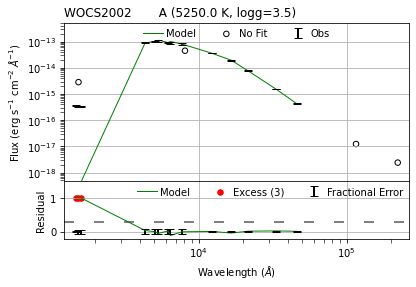

In [2]:
# initialising the binary star
cycle = 1
star  = BinaryStar(name           = 'WOCS2002',                           # name of the star
                  model_to_fit    = 'Koe_logg7.0',                        # model names same as in "models" folder
                  dir_obs         = 'data/vosa_results_38873/objects/',   # location of VOSA SED result files
                  distance        = 831.76,                               # distance in pc
                  distance_err    = 11.0,                                 # distance error in pc
                  free_para       = 3,                                    # number of free parameters
                  filters_to_drop = ['GALEX/GALEX.FUV','WISE/WISE.W3'])   # list of filters not to be fitted 

# Read data from A component fitted with VOSA
star.read_A_comp_from_VOSA(verbose=False)
    
# visualising the SED for the A component
star.visualise_A_component_SED(excess_cutoff=0.3)

# loading and combining the synthetic flux file
star.flux_model, star.T_list = read_model_file(star.model_to_fit, star.flux_A.index,verbose=False)
star.append_residual_to_model()

# initialising scaling factor grid
#    SF limits are calculated from radius limits (0.001 and 2 Rsun by default) 
sf_min, sf_max = sf_from_R(0.001,star.distance), sf_from_R(2,star.distance)
star.sf_list = np.geomspace(sf_min, sf_max, num=300)

# Getting lowest chi2 fit and plotting SEDs

- If you have modified something and want to recalculate the chi2, use `refit=False` in `calculate_chi2`


RUNNING: calculate_chi2 
     Teff            sf       chi2    chi2_r      vgf2     vgfb2  sf_index
0  14750  2.297417e-25  11.708532  1.064412  0.955649  0.180195     113.0
1  14500  2.543318e-25  12.208154  1.109832  1.001077  0.197299     115.0
2  17500  1.071600e-25  12.400061  1.127278  1.018477  0.203360      98.0
3  17250  1.127491e-25  12.496589  1.136054  1.027254  0.211818      99.0
4  14000  2.962389e-25  12.658210  1.150746  1.042004  0.192778     118.0
Computation time = 13.5 s

B-component fitting parameters: T=14750,sf=2.30e-25,R=0.017683,L=0.013333


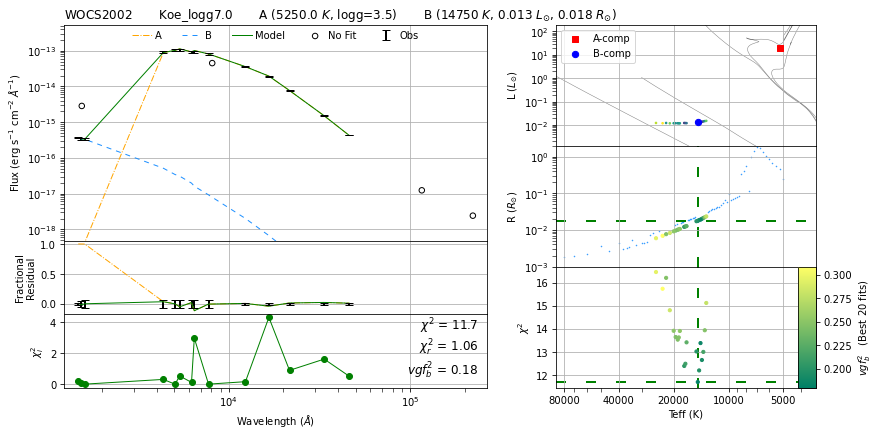

In [3]:
calculate_chi2(star, star.sf_list, star.T_list, cycle=cycle,refit=False)
get_parameters_from_chi2_minimization(star)
star.create_binary_SED_plot(cycle,save_plot=True)

# Noisy iterations
- Adding Gaussian noise to the data and fitting again.
- After N iterations, use the distributions of best fit temperature, luminosity and radius to get realistic errors.
- If errors in temperature are less than step size, the step size is quoted as the errors.  
- `save_log` saves the calculated parameters in a file for easier analysis


RUNNING: calculate_chi2_for_iterations 
    seed   Teff            sf      chi2    chi2_r      vgf2     vgfb2  \
0  31.0  14750  2.297417e-25  7.539412  0.685401  0.620984  0.143740   
1  88.0  13250  4.019064e-25  8.003137  0.727558  0.669439  0.159481   
2  30.0  14250  2.675970e-25  8.118000  0.738000  0.701586  0.210945   
3  34.0  21000  4.998339e-26  8.357755  0.759796  0.726052  0.218151   
4  95.0  14750  2.297417e-25  8.871352  0.806487  0.754188  0.168086   

     radius  luminosity  
0  0.017683    0.000176  
1  0.023388    0.000308  
2  0.019084    0.000205  
3  0.008248    0.000038  
4  0.017683    0.000176  
Computation time = 127.40625 s

B-component fitting parameters (median+-1sigma):
   T=15000+250-2250, sf=2.18e-25+1.06e-25-2.34e-26, R=0.017239+0.004851-0.000899, L=0.013553+0.007010-0.012689


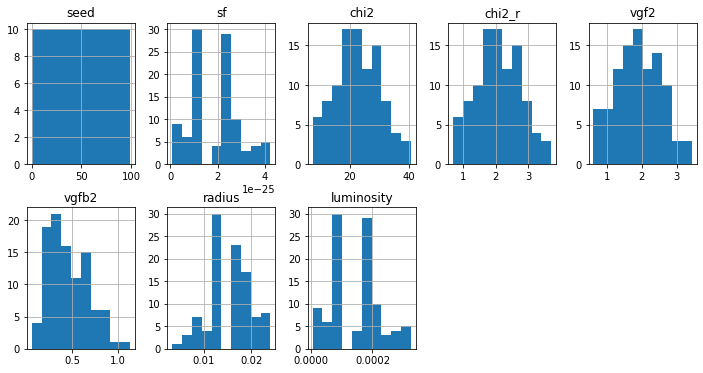

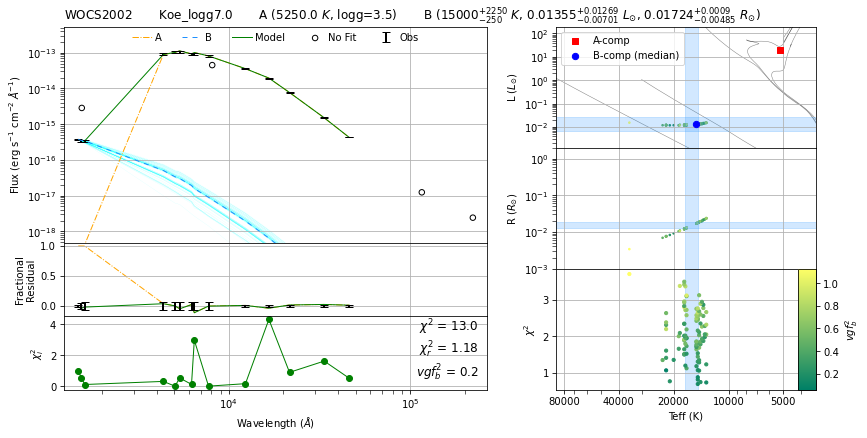

Creating log_file.csv and saving log


In [4]:
data_chi_iterations = calculate_chi2_for_iterations(star, star.sf_list, star.T_list, cycle=cycle, total_iterations=100,refit=False) 

data_chi_iterations.hist(layout=(2,5),figsize=(12,6))
get_parameters_from_iterations(star)
star.create_binary_SED_plot_iterations(cycle=cycle,save_plot=True)

save_log(star,cycle)